# Segmenting or quantifying foaminess of macrophages


In [1]:
import napari
from macrohet import dataio, tile, visualise, tools
import btrack
print(btrack.__version__)
import os
import json 
import numpy as np
from tqdm.auto import tqdm
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color
import matplotlib.pyplot as plt

scale_factor = 5.04
ndim = 2

0.6.1.dev30


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = 3
column = 5

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [5]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=1,
                             set_time = 0,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

In [6]:
gfp_t0 = images[0,0,...]

# Load tracks

In [7]:
tracks_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    tracks = hdf.tracks
    segmentation = hdf.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=ndim)

[INFO][2023/06/01 04:29:12 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/01 04:29:12 PM] Loading tracks/obj_type_1
[INFO][2023/06/01 04:29:12 PM] Loading LBEP/obj_type_1
[INFO][2023/06/01 04:29:12 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/01 04:29:21 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/01 04:29:21 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


In [8]:
tracks_t0 = [t for t in tracks if t.in_frame(0)] #and len(t) == 75]

In [9]:
len(tracks_t0)

627

In [10]:
tracks_t0[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,area,major_axis_length,Infected,mean_intensity,minor_axis_length
0,423,0,723.909912,33.010132,0.000000,423,423,5,0,False,-0.105442,23203.0,344.046997,1.0,"(3,) array",87.624420
1,423,1,727.771362,38.211437,0.000000,423,423,5,0,False,-0.105384,25659.0,410.356964,1.0,"(3,) array",95.545296
2,423,2,730.887634,26.283424,0.000000,423,423,5,0,False,-0.172310,19483.0,281.636444,1.0,"(3,) array",89.392372
3,423,3,732.147583,27.895367,0.000000,423,423,5,0,False,-0.172292,22840.0,325.991333,1.0,"(3,) array",92.556488
4,423,4,730.891357,33.019173,0.000000,423,423,5,0,False,-0.152742,23224.0,373.707001,1.0,"(3,) array",80.582886
5,423,5,731.606384,30.630995,0.000000,423,423,5,0,False,-0.151112,21159.0,351.986481,1.0,"(3,) array",78.869858
6,423,6,732.788086,30.744682,0.000000,423,423,5,0,False,-0.169930,21750.0,358.099487,1.0,"(3,) array",79.728958
7,423,7,733.528625,27.149408,0.000000,423,423,5,0,False,-0.195798,15457.0,294.958893,0.0,"(3,) array",67.987579
8,423,8,733.524414,32.480957,0.000000,423,423,5,0,False,-0.201907,21431.0,385.717529,1.0,"(3,) array",73.575928
9,423,9,735.238953,29.900726,0.000000,423,423,5,0,False,-0.251289,22385.0,409.529633,1.0,"(3,) array",79.070381


In [9]:
col_segmentation = btrack.utils.update_segmentation(segmentation, tracks_t0, scale = (scale_factor,)*ndim)

In [10]:
col_seg_t0 = col_segmentation[0]

In [29]:
v = napari.Viewer()

v.add_image(gfp_t0, colormap='green')

v.add_labels(col_seg_t0)

v.add_image(glimpse)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'glimpse' at 0x7f620e31fa30>

In [15]:
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_t0, ndim=ndim)

In [ ]:
v.add_tracks(napari_tracks, properties=properties, graph=graph, scale = (100,scale_factor,scale_factor),)

In [ ]:
v.add_image(gfp_glimpse)

### Corpus of GFP glimpses at t0 

In [11]:
glimpse_stack = list()
for segment_ID in tqdm(range(1, 13)):#np.max(col_seg_t0))):
    segment = col_seg_t0 == segment_ID
    gfp_isolate = segment * gfp_t0
    non_zero_indices = np.nonzero(gfp_isolate)
    min_row, max_row = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
    min_col, max_col = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])
    gfp_glimpse = gfp_isolate[min_row:max_row+1, min_col:max_col+1]
    glimpse_stack.append(gfp_glimpse)
# np.stack(glimpse_stack, axis = 0)

  0%|          | 0/12 [00:00<?, ?it/s]

In [16]:
glimpse_stack

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

In [17]:
glimpse_stack[0].shape

(163, 260)

In [18]:
%%time
# Calculate the GLCM
distances = [1]  # specify the distances between pixels to consider 5 will CRASH KERNEL
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # specify the angles for texture measurements
glcm = greycomatrix(glimpse_stack[0], distances, angles, levels=2**8, symmetric=True, normed=True)

# Calculate texture properties from the GLCM
contrast = greycoprops(glcm, 'contrast')
homogeneity = greycoprops(glcm, 'homogeneity')
energy = greycoprops(glcm, 'energy')

# Print the computed texture features
print('Contrast:', contrast)
print('Homogeneity:', homogeneity)
print('Energy:', energy)

Contrast: [[ 72.28678021 176.72319939 124.46749763 130.29939463]]
Homogeneity: [[0.54523813 0.49829521 0.52782347 0.50355174]]
Energy: [[0.3221897  0.31395336 0.31936676 0.31625851]]
CPU times: user 37.2 ms, sys: 157 µs, total: 37.4 ms
Wall time: 35.9 ms


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

  0%|          | 0/30 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

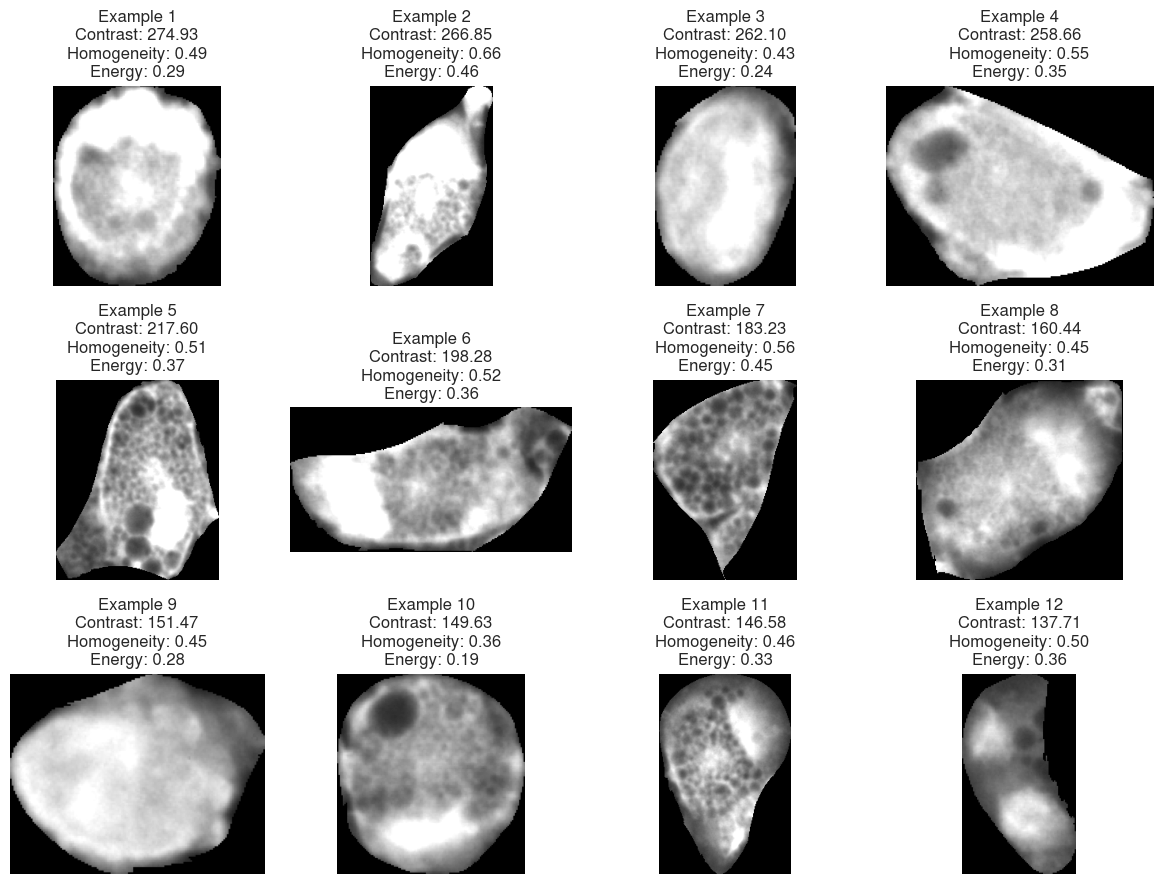

In [33]:
# Initialize lists to store the texture properties
contrast_values = []
homogeneity_values = []
energy_values = []

# Iterate over the glimpses and calculate the GLCM and texture properties
for glimpse in tqdm(glimpse_stack[0:30], total=len(glimpse_stack[0:30])):

    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = greycomatrix(glimpse, distances, angles, levels=2**8, symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]

    # Append the texture properties to the respective lists
    contrast_values.append(contrast)
    homogeneity_values.append(homogeneity)
    energy_values.append(energy)

# Sort the lists in descending order to find the most distinct examples
sorted_indices = np.argsort(contrast_values + homogeneity_values + energy_values)[::-1][:12]

# Plot the glimpses with the most extreme GLCM measurements
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i, idx in enumerate(sorted_indices):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(glimpse_stack[idx], cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Example {i+1}\nContrast: {contrast_values[idx]:.2f}\nHomogeneity: {homogeneity_values[idx]:.2f}\nEnergy: {energy_values[idx]:.2f}')

plt.savefig('/mnt/DATA/macrohet/upstream_development/segmentation/vaculation/initial_masked_GLCM_measures.png', 
            dpi = 314, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [45]:
import warnings
warnings.filterwarnings("ignore")
for px_d in tqdm([30, 50, 100]):
    # Initialize lists to store the texture properties
    contrast_values = []
    homogeneity_values = []
    energy_values = []

    output_dir = f'/mnt/DATA/macrohet/upstream_development/segmentation/vaculation/glcm_pixd_{px_d}'
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over the glimpses and calculate the GLCM and texture properties
    for glimpse in tqdm(glimpse_stack[0:12], total=len(glimpse_stack[0:12]), leave = False):
        distances = [px_d]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = greycomatrix(glimpse, distances, angles, levels=2**8, symmetric=True, normed=True)
        contrast = greycoprops(glcm, 'contrast')[0, 0]
        homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
        energy = greycoprops(glcm, 'energy')[0, 0]

        # Append the texture properties to the respective lists
        contrast_values.append(contrast)
        homogeneity_values.append(homogeneity)
        energy_values.append(energy)

    # Sort the lists in descending order to find the most distinct examples
    sorted_indices_contrast = np.argsort(contrast_values)[::-1][:12]
    sorted_indices_homogeneity = np.argsort(homogeneity_values)[::-1][:12]
    sorted_indices_energy = np.argsort(energy_values)[::-1][:12]

    # Plot and save the glimpses with the most extreme GLCM measurements (Contrast)
    fig_contrast, axes_contrast = plt.subplots(3, 4, figsize=(12, 9))
    for i, idx in enumerate(sorted_indices_contrast):
        row = i // 4
        col = i % 4
        axes_contrast[row, col].imshow(glimpse_stack[idx], cmap='gray')
        axes_contrast[row, col].axis('off')
        axes_contrast[row, col].set_title(f'Example {i+1}\nContrast: {contrast_values[idx]:.2f}\nHomogeneity: {homogeneity_values[idx]:.2f}\nEnergy: {energy_values[idx]:.2f}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'px_d_{px_d}_contrast_sorted_GLCM_measures.png'), dpi=314, bbox_inches='tight')
    plt.close(fig_contrast)

    # Plot and save the glimpses with the most extreme GLCM measurements (Homogeneity)
    fig_homogeneity, axes_homogeneity = plt.subplots(3, 4, figsize=(12, 9))
    for i, idx in enumerate(sorted_indices_homogeneity):
        row = i // 4
        col = i % 4
        axes_homogeneity[row, col].imshow(glimpse_stack[idx], cmap='gray')
        axes_homogeneity[row, col].axis('off')
        axes_homogeneity[row, col].set_title(f'Example {i+1}\nContrast: {contrast_values[idx]:.2f}\nHomogeneity: {homogeneity_values[idx]:.2f}\nEnergy: {energy_values[idx]:.2f}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'px_d_{px_d}_homogeneity_sorted_GLCM_measures.png'), dpi=314, bbox_inches='tight')
    plt.close(fig_homogeneity)

    # Plot and save the glimpses with the most extreme GLCM measurements (Energy)
    fig_energy, axes_energy = plt.subplots(3, 4, figsize=(12, 9))
    for i, idx in enumerate(sorted_indices_energy):
        row = i // 4
        col = i % 4
        axes_energy[row, col].imshow(glimpse_stack[idx], cmap='gray')
        axes_energy[row, col].axis('off')
        axes_energy[row, col].set_title(f'Example {i+1}\nContrast: {contrast_values[idx]:.2f}\nHomogeneity: {homogeneity_values[idx]:.2f}\nEnergy: {energy_values[idx]:.2f}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'px_d_{px_d}_energy_sorted_GLCM_measures.png'), dpi=314, bbox_inches='tight')
    plt.close(fig_energy)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

  0%|          | 0/12 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

  0%|          | 0/12 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` 

# Conclusion:

Doesn't look like GLCM is capable of segregating based on foaminess

In [50]:
from skimage import io, filters, measure


  0%|          | 0/12 [00:00<?, ?it/s]

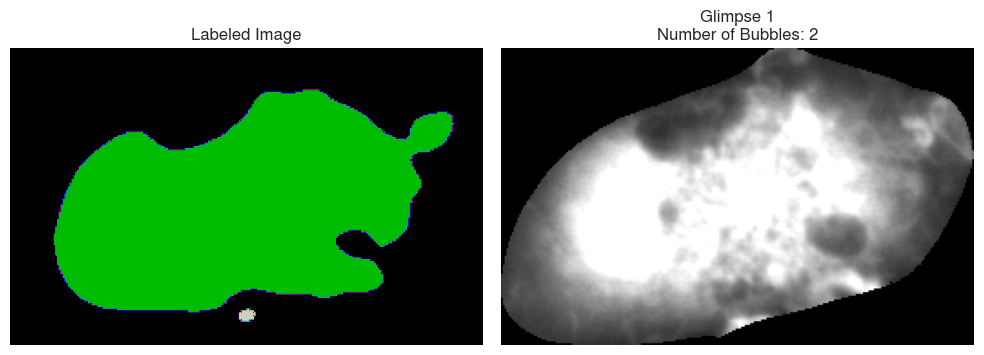

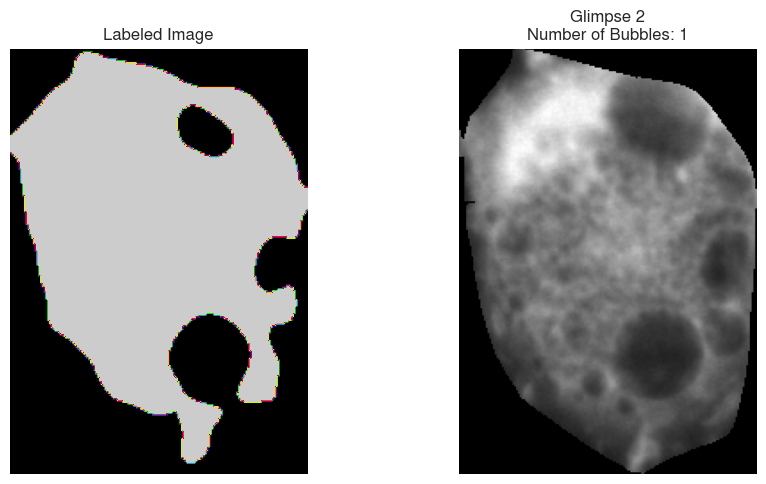

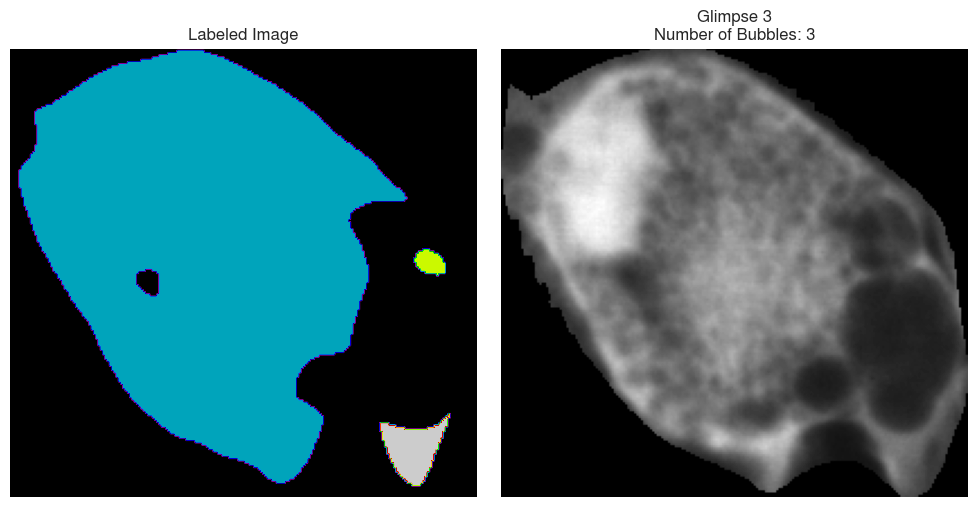

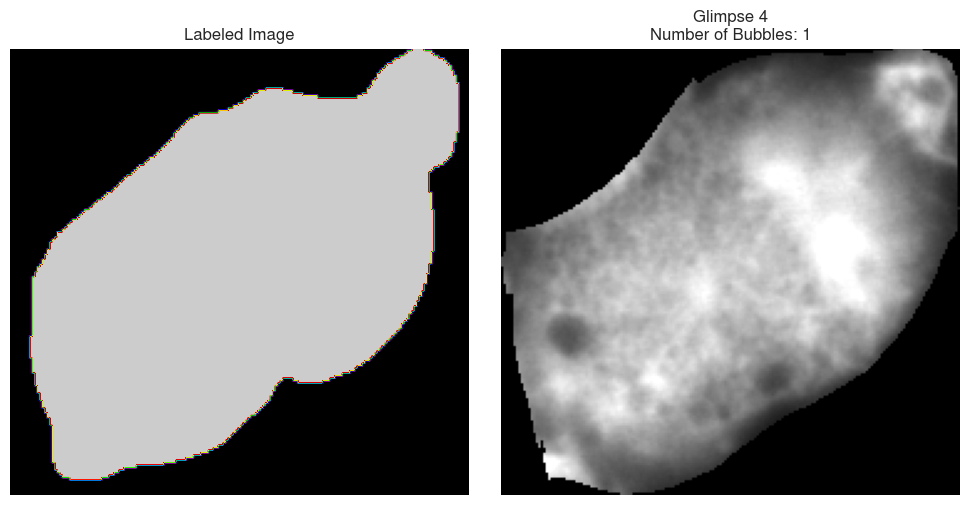

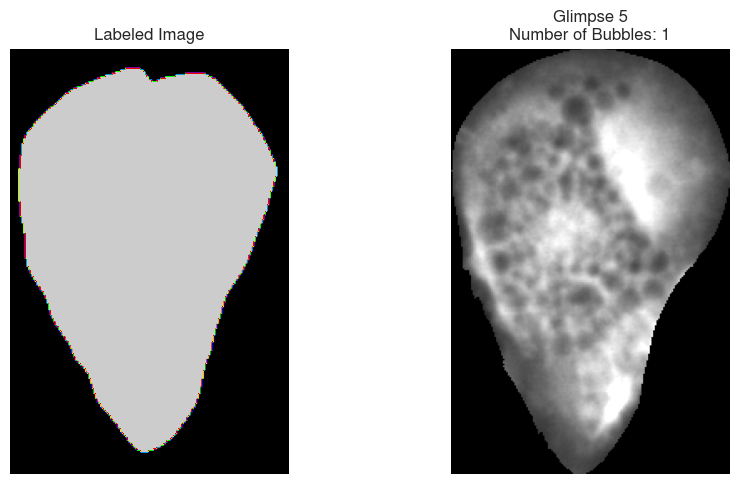

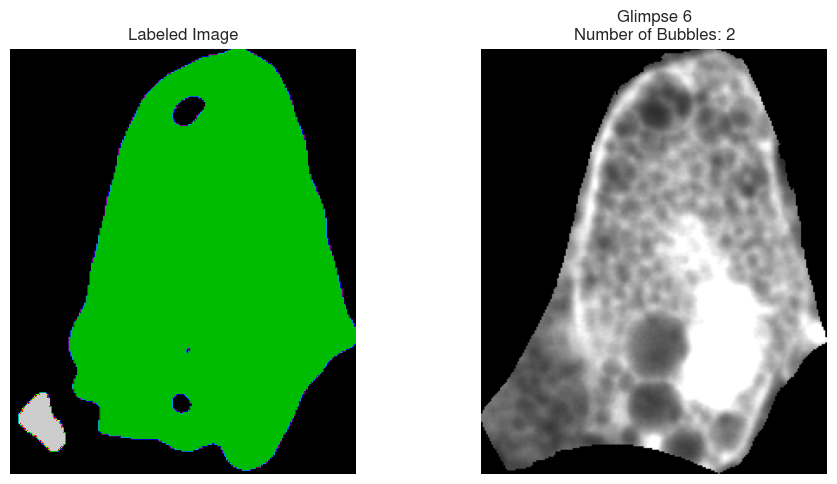

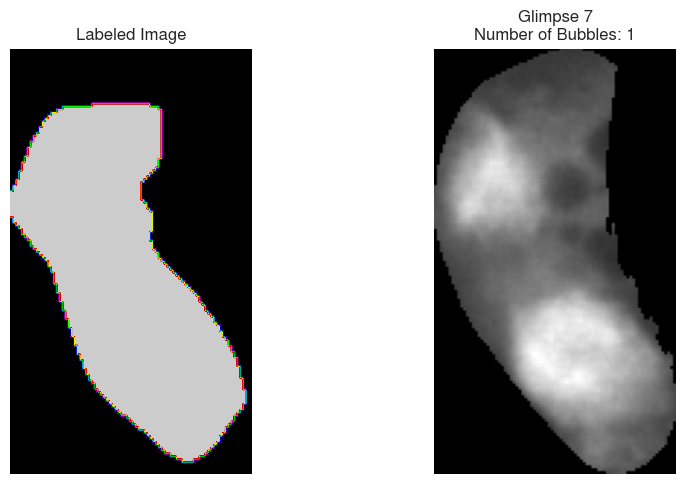

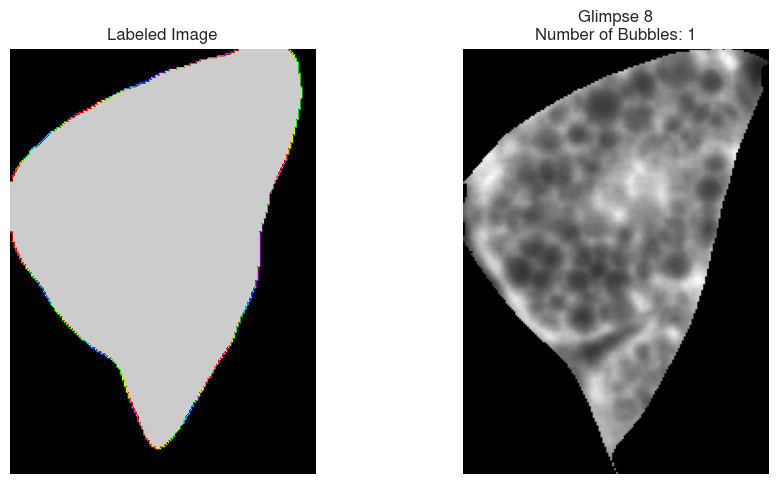

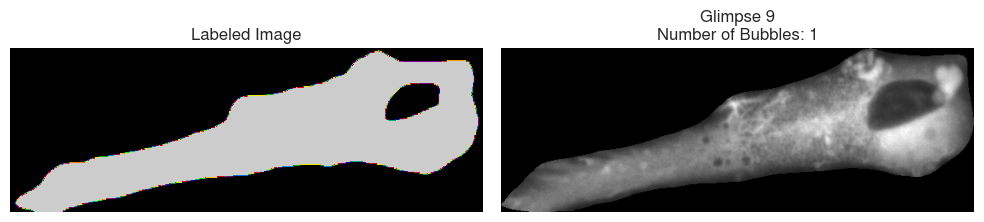

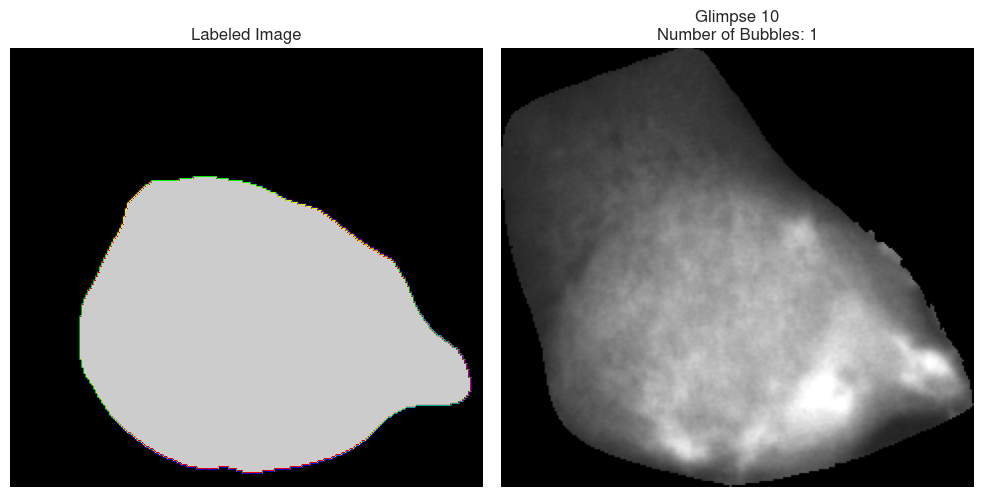

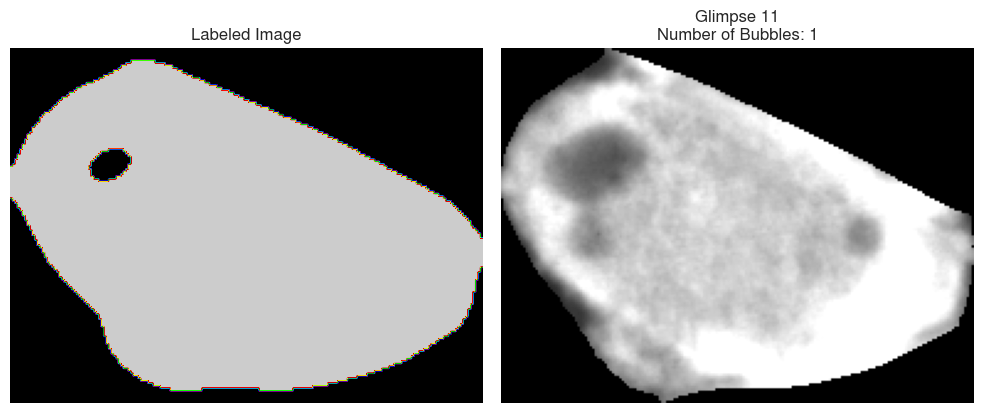

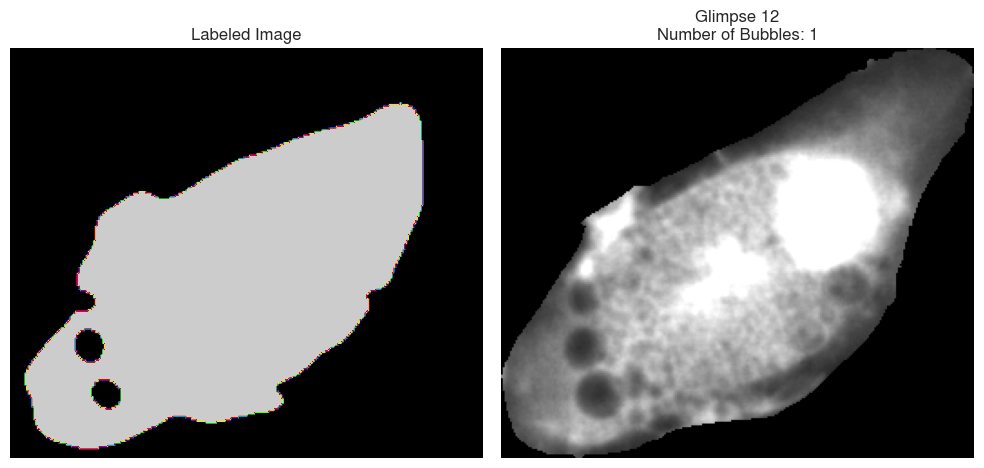

In [58]:
import matplotlib.pyplot as plt
from skimage import io, filters, measure

# Iterate over the glimpses
for i, glimpse in tqdm(enumerate(glimpse_stack[0:12]), total=len(glimpse_stack[0:12]), leave=False):

    # Preprocess the image if needed (e.g., Gaussian blur)
    preprocessed_image = filters.gaussian(glimpse, sigma=5)

    # Segment the image using thresholding
    threshold = filters.threshold_otsu(preprocessed_image)
    segmented_image = preprocessed_image > threshold

    # Perform connected component analysis
    labeled_image = measure.label(segmented_image)

    # Count the number of regions (bubble-like features)
    num_bubbles = len(measure.regionprops(labeled_image))

    # Plot the labeled image and glimpse side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(labeled_image, cmap='nipy_spectral')
    ax1.set_title('Labeled Image')
    ax1.axis('off')

    ax2.imshow(glimpse, cmap='gray')
    ax2.set_title(f'Glimpse {i+1}\nNumber of Bubbles: {num_bubbles}')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()


# Conclusion: classical image processing doesnt work

What if I just run a series of intersections through the middle and measure the bumpiness of px intensity?

### Stardist?

In [12]:
glimpse_stack[4][glimpse_stack[4] == 0  ] = 255

In [13]:
viewer = napari.Viewer()

viewer.add_image(np.max(glimpse_stack[4]) - glimpse_stack[4])

/home/dayn/analysis/btrack/btrack/dataio.py:3: UserWarning: `btrack.dataio` has been deprecated. Please use `btrack.io` subpackage instead.
  warnings.warn(  # noqa: B028


Assistant skips harvesting pyclesperanto as it's not installed.


<Image layer 'Image' at 0x7f7074644370>